In [1]:
import warnings; warnings.simplefilter('ignore')

# Sudden Landslide Identification Product ( SLIP )  
 
## What to expect from this notebook  
  
- Introduction to the SLIP algorithm 
- describing change detection in the context of datacube
- Detailed band math equations for SLIP filtering  
- Illustrate the step by step evolution of a SLIP product  
----

## SLIP

SLIP is used to automate the detection of Landslides. A SLIP product is the result of filtering based on per-pixel changes in both *soil moisture* and *vegetation* in areas with *high elevation gradients*.  All of which (with the exception of elevation gradients) can be computed using simple bandmath equations.

## Data used  
  
SLIP makes use of the following Landsat 7 Surface Reflectance Bands:  
- RED,  
- NIR,  
- SWIR1  
- CF_MASK  

SLIP makes use of the following ASTER GDEM V2 bands:  
- dem  

## Algorithmic Process  

Algorithmically speaking, SLIP is a series of  per-pixel filter operations acting on relationships between NEW(current) and BASELINE(historical) values of an area. The remaining pixels after filter operations will be what SLIP classifies as landslides.  Itemized in the list below are operations taken to create a SLIP product:  

- Import and initialize datacube
- Load Geographic area
- Remove clouds and no-data values
- Label this product NEW
- Generate a rolling average composite of NEW  
- Label the rolling average composite BASELINE
- Filter in favor of sufficiently large changes in vegetation (using NDWI values derived from NEW and BASELINE)  
- Filter in favor of sufficiently large increases in RED reflectance(using RED band values from NEW and BASELINE)  
- Generate a slope-mask(using ASTERDEM V2 data) 
- Filter in favor of areas that have a high enough slope(Landslides don't happen on flat surfaces)   

----  
  
### Import and initialize datacube  
The following code connects to the datacube and accepts 'SLIP' as an app-name.  
  

In [2]:
import datacube  
dc = datacube.Datacube(app = 'SLIP')  

###  Load Geographic area  

The region loaded in this example contains a detectable landslide in rural Colombia(province of Antioquia). This landslide is first detectable on October, 31st, 2015.

In [3]:
import datetime

# define geographic boundaries in (min, max) format
lon = (-75.89456344558067,-75.88026493389728)
lat = (5.934816520019737,5.944990460054757)

# define date range boundaries in (min,max) format
date_range =(datetime.datetime(2014,1,1), datetime.datetime(2016,1,1))

# define product and platform to specify our intent to load Landsat 7 sr products
platform = 'LANDSAT_7'
product = 'ls7_ledaps_salgar_colombia'  

# define desired bands. For SLIP, only red,nir,swir and cf_mask will be necessary. 
desired_bands = ['red','nir','swir1','cf_mask']  
  
#add blue and green bands since they're needed for visualizing results(RGB)
desired_bands = desired_bands + ['green', 'blue']
  
# load area. Should result in approximately 15 acquisitions between 2014 and 2016      
landsat = dc.load(product = product,\
	platform = platform,\
	lat = lat,\
	lon = lon,\
	time = date_range,\
	measurements = desired_bands)


### Remove Clouds,Water,Shadows,Snow and NoData values  

Use 'cf_mask' to filter out points that can not possibly have detectable landslides on them. Primarily: water, cloud, cloud shadows, snow, no-data pixels.  

Detailed below are `cf_mask` encodings for those values.  
  <br><br>
\begin{array}{|c|c|}
\hline cf\_mask \_ encoding & Band Name  \\\hline
  0  & clear \\\hline
  1  & water \\\hline
  2  & shadow \\\hline
  3  & cloud \\\hline
  4  & snow \\\hline
  255  & nodata \\\hline
\end{array}
<br><br>
It is clear that we're only interested areas where `cf_mask == 0`. The following illustrates `cf_mask` being used to filter landsat imagery.  

In [4]:
# Filter in favor of clear pixels.
landsat = landsat.where(landsat.cf_mask == 0)

#Filter out negative values. (This includes noise and no-data values of -9999) 
landsat = landsat.where(landsat >= 0) 


The code above applies `np.nan` values globally across all bands to any (time,lat,lon) coordinate pairs that do not have cf_mask == 0. Similarly, it applies `np.nan` values that are below zero. 

### Visualization 
This step is optional, but useful to those seeking a step by step validation of SLIP. The following code utilizes a one-off plotting utility `dc_displayutil` to visualize true-color representations of our loaded scene.  
<br>

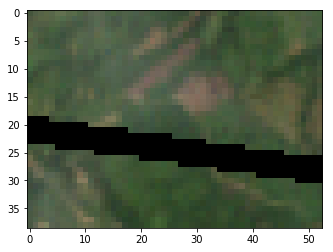

In [5]:
from utils.dc_displayutil import display_at_time
display_at_time([landsat], time = datetime.datetime(2015,8,31), width = 1, w = 12)

<br>
Notice that there is a black line stretching across the figure above. This is the result of a scanline corrector(SLC) malfunction on LANDSAT 7. In this example, the loss of data in that scanline region will not prevent the detection of the visible landslide centered at (32,15).

----  

## Change detection
  
In the context of SLIP, Change detection happens through the comparison of 'current' values against 'past' values.  
<br>
Trivialized Example:  
<br>
$$ \Delta Value = (Value_{new} - Value_{old})/ Value_{old} $$  

<br>
It is easy to define NEW as the current value being analyzed.   
<br>

In [6]:
new = landsat  

<br>
However, *OLD* can have varying interpretations.
In SLIP, OLD values(referred to in code as BASELINE values) are simply rolling averages of not-nan values leading up to the date in question.  
  
  <br>
The following figure illustrates such a compositing method:  
  
<br><br>  

![img](diagrams/slip/comp_00.png)
<!-- ![img](avg_compositing.png) --> 
  
<br>
In the figure above, t4 values are the average of t1-t3 (assuming a window size of 3)  

<br>
The code below composites with a window size of 5. 

In [7]:
from utils.dc_baseline import generate_baseline  
#Generates a moving average of n values leading up to current time  
baseline = generate_baseline(landsat, composite_size = 5, mode = 'average')  

It is important to note that compositing will shorten the length of `baseline`'s time domain by the window size.(Since ranges less than the composite size are not computed). For a composite size of 5, `new`'s first 5 time values will not have composite values.  
<br>

In [8]:
(len(new.time), len(baseline.time))

(15, 10)

<br>
#### What this composite looks like 

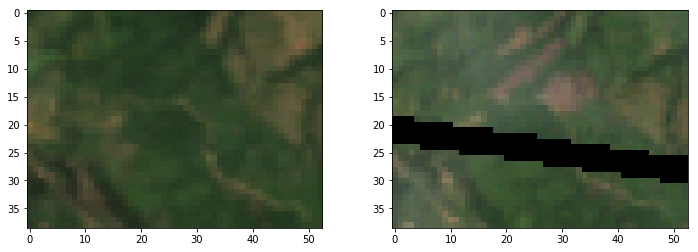

In [9]:
display_at_time([baseline, new], time = datetime.datetime(2015,8,31), width = 2, w = 12)

The baseline composite is featured in the figure above(left). It represents what was typical for the past five acquisitions *'leading-up-to'* (2015,8,31). Displayed next to it(right) is the true-color visualization of the acquisition *'at'* (2015,8,31). The `new` object contains unaltered LS7 scenes that are index-able  using a date like (2015,8,31). The `baseline` object contains a block of composites of those landsat scenes that is index-able the same way,  

----  
  
## NDWI (Nomalized Difference Water Index) 

SLIP makes the major assumption that landslides will strip a hill/mountain-side of all of its vegetation.  
  
SLIP uses [NDWI](https://en.wikipedia.org/wiki/Normalized_difference_water_index), an index used to monitor water content of leaves, to track the existence of vegetation on a slope. At high enough levels, leaf water content change can no longer be attributed to something like seasonal fluctuations and will most likely indicate a change in the existence of vegetation.  
<br>
#### NDWI BANDMATH

NDWI is computed on a per-pixel level and involves arithmetic between NIR(Near infrared) and SWIR1(Short Wave Infrared) values. 
NDWI is computed for both NEW and BASELINE imagery then compared to yield NDWI change. The equations bellow detail a very simple derivation of change in NDWI: 


$$ NDWI_{NEW} =  \frac{NIR_{NEW} - SWIR_{NEW}}{NIR_{NEW} + SWIR_{NEW}}$$  
  <br><br>
$$ NDWI_{BASELINE} =  \frac{NIR_{BASELINE} - SWIR_{BASELINE}}{NIR_{BASELINE} + SWIR_{BASELINE}}$$  
  <br><br>
$$\Delta NDWI = NDWI_{NEW} - NDWI_{BASELINE}$$  


<br>
The code is just as simple:  

In [10]:
ndwi_new = (new.nir- new.swir1)/(new.nir + new.swir1)
ndwi_baseline = (baseline.nir - baseline.swir1)/ (baseline.nir + baseline.swir1)
ndwi_change = ndwi_new - ndwi_baseline

#### Filtering NDWI
In the context of code, you can best think of filtering as a peicewise transformation that assigns a `nan` (or null) value to points that fall below our minimum change threshold. (For SLIP that threshold is 20%) 
  
  <br>

$$  ndwi\_filter(Dataset) = \left\{
     \begin{array}{lr}
       Dataset & : |  \Delta NDWI(Dataset)  | > 0.2\\
       np.nan & : |  \Delta NDWI(Dataset)  | \le 0.2
     \end{array}
   \right.\\ $$  
   
   <br>

In code, it's even simpler:  

In [11]:
new_ndwi_filtered = new.where(abs(ndwi_change) > 0.2)

<br>
#### How far NDWI filtering gets you  

A SLIP product is the result of a process of elimination.  NDWI is sufficient in eliminating a majority of non-contending areas early on in the process. Featured below is what is left of the original image after having filtered for changes in NDWI  

<br>


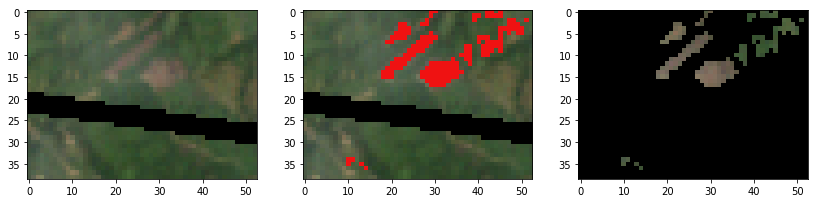

In [12]:
display_at_time([new, (new, new_ndwi_filtered),new_ndwi_filtered], time = datetime.datetime(2015,8,31), width = 3, w =14)

Highlighted in the center picture are values that meet our NDWI change expectations. Featured in the right-most image is what remains of our original image after NDWI filtering.  
  

----  
  
## RED  Reflectance  
SLIP makes another important assumption about Landslides. 
On top of stripping the Slope of vegetation, a landslide will reveal a large layer of previously vegetated soil. Since soil reflects more light in the RED spectral band than highly vegetated areas do, SLIP looks for increases in the RED bands. This captures both the loss of vegetation, and the unearthing of soil.    

#### RED change bandmath
Red change is computed on a per-pixel level and involves arithmetic on the RED band values.  The derivation of RED change is simple: 
<br><br>

$$ \Delta Red = \frac{RED_{NEW} - RED_{BASELINE}}{RED_{BASELINE}} $$

<br><br>
The code is just as simple:

In [13]:
red_change = (new.red - baseline.red)/(baseline.red)

<br>
#### Filtering for RED reflectance increase
Filtering RED reflectance change is just like the piecewise transformation used for filtering NDWI change.  
  
<br>  
$$  red\_filter(Dataset) = \left\{
     \begin{array}{lr}
       Dataset & :   \Delta red(Dataset)   > 0.4\\
       np.nan & :   \Delta red(Dataset)   \le 0.4
     \end{array}
   \right.\\ $$  

<br>

In Code:


In [14]:
new_red_and_ndwi_filtered = new_ndwi_filtered.where(red_change > 0.4)

<br>

#### How much further RED reflectance filtering gets you
Continuing SLIP's process of elimination, *Red increase* filtering will further refine the area of interest to areas that, upon visual inspection appear to be light brown in color.  

<br><br>

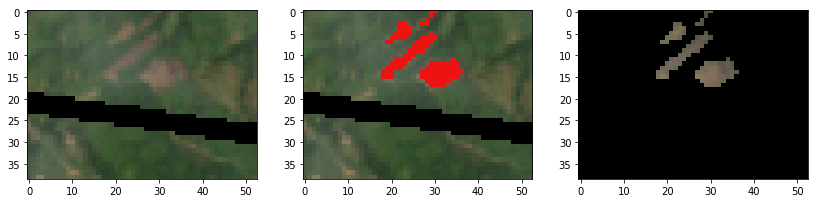

In [15]:
display_at_time([new, (new, new_red_and_ndwi_filtered),new_red_and_ndwi_filtered], time = datetime.datetime(2015,8,31), width = 3, w = 14)

<br><br>  
----

## ASTER Global Elevation Models

Aster GDEM models provide elevation data for each pixel expressed in meters.  For SLIP height is not enough to determine that a landslide can happen on a pixel. SLIP focuses on areas with high elevation Gradients/Slope (Expressed in non-radian degrees).The driving motivation for using slope based filtering is that landslides are less likely to happen in flat regions. 

#### Loading the elevation model  
<br>

In [16]:
aster = dc.load(product="terra_aster_gdm_salgar_colombia",\
	lat=lat,\
	lon=lon,\
	measurements=[ 'dem'])  

<br>
#### Calculating Angle of elevation   

A gradient is generated for each pixel using the four pixels adjacent to it, as well as a rise/run formuala. 

<br><br>
$$ Gradient = \frac{Rise}{Run}  $$  
<br><br>
Basic trigonometric identities  can then be used to derive the angle:   
<br><br>
    
$$ Angle of Elevation = \arctan(Gradient) $$
   <br><br>  
   
When deriving the angle of elevation for a pixel, two gradients are available. One formed by the bottom pixel and top pixel, the other formed by the right and left pixel. For the purposes of identifying landslide causing slopes, the greatest of the two slopes will be used.  
The following image describes the process for angle-of-elevation calculation for a single pixel within a grid of DEM pixels      
  
   <br><br> 
    
![img](diagrams/slip/derivation.png)
  
  <br><br>  
  
The vagaries of implementation have been abstracted away by `dc_demutils`. It's used to derive a slope-mask. A slope-mask in this sense, is an array of `true` and `false` values based on whether or not that pixel meets a minimum angle of elevation requirement.  Its use is detailed below.  
<br><br>

In [18]:
from utils.dc_slip import create_slope_mask
# Create a slope-mask. False: if pixel <15 degees; True: if pixel > 15 degrees;  
is_above_slope_threshold = create_slope_mask(aster, degree_threshold = 15,resolution = 30) 

<br>
#### Filtering out pixels that don't meet requirements for steepness
<br>
Filtering based on slope is a peicewise transformation using a derived slopemask:   
  
<br>  
  
$$  slope\_filter(Dataset) = \left\{
     \begin{array}{lr}
       Dataset & :   is\_above\_degree\_threshold(Dataset, 15^{\circ})   = True\\
       np.nan &  :    is\_above\_degree\_threshold(Dataset, 15^{\circ})   = False\\
     \end{array}
   \right.\\ $$  
    
<br>  
Its use in code:  

In [19]:
slip_product = new_red_and_ndwi_filtered.where(is_above_slope_threshold)

<br><br>
#### Visualising our final SLIP product


The final results of SLIP are small regions of points with a high likelihood of landslides having occurred on them. Furthermore there is no possibility that detections are made in flat areas(areas with less than a $15^{\circ}$ angle of elevation.  
  
<br>

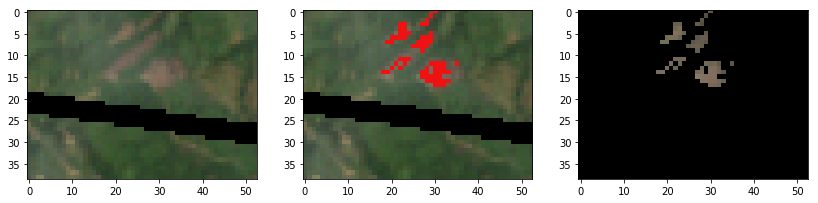

In [20]:
display_at_time([new, (new, slip_product),slip_product], time = datetime.datetime(2015,8,31), width = 3, w = 14)

<br><br>  
## Reviewing the evolution of the SLIP product

The following visualizations will detail the evolution of the SLIP product from the previous steps.

Order of operations:  
- NDWI change Filtered
- RED increase Filtered
- Slope Filtered

#### Visualization

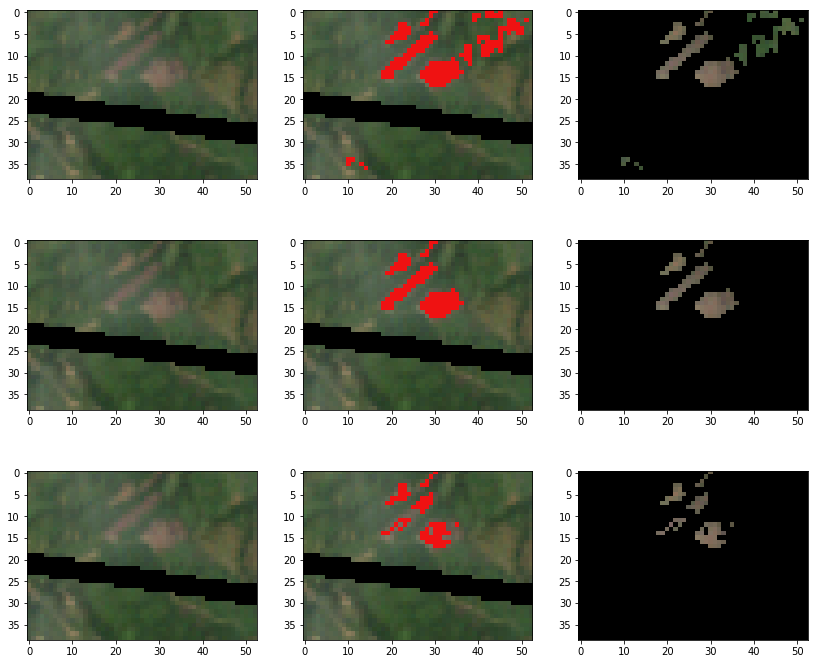

In [21]:
display_at_time([new, (new,new_ndwi_filtered),new_ndwi_filtered,new,  (new, new_red_and_ndwi_filtered),new_red_and_ndwi_filtered, new, (new, slip_product),slip_product], time = datetime.datetime(2015,8,31), width = 3, w = 14, h = 12)

## Visual comparison of NEW and BASELINE 

In the name of validating results, it makes sense to compare the SLIP product generated for (2015,8, 31) to the composited scene representing what is considered to be "normal" for the last 5 acquisitions.  

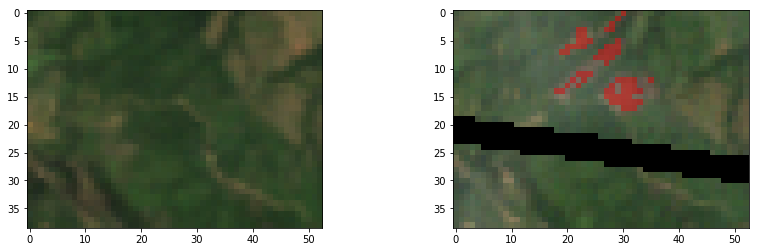

In [22]:
display_at_time([baseline, (new,slip_product)], time = datetime.datetime(2015,8,31), width = 2, mode = 'blend', color = [210,7,7] , w = 14)

Based on the results displayed above, it appears that SLIP has successfully classified major changes in imagery, and possibly, even detected a landslide.  